# Projeto 1 - Ciência dos Dados

Nome: Alexia Barbosa Pires

Nome: Ellen Coutinho Lião da Silva

___
Carregando algumas bibliotecas:

In [62]:
%matplotlib inline
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import re
import os

In [63]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\ellen\Downloads\cdados_p1\repositorio_oficial\22-2a-cd-p1-grupo_alexiabp\notebooks


___
## Classificador automático


O nosso tema é a diferenciação entre os momentos de alta e da queda da moeda americana, o Dólar! Pegamos nossa base de dados no site MoneyTimes, extraímos e classificamos manualmente notícias acerca deste tema.

Esse procedimento foi feito utilizando a seguinte classificação:
- Target 0 = neutro, para notícias em que o dólar está estável ou não é mencionado;
- Target 1 = positivo, para notícias que mencionam a alta/valorização da moeda no cenário mundial;
- Target 2 = negativo, para notícias que mencionam a queda/desvalorização da moeda no cenário mundial. 

O Classificador Naive-Bayes, neste projeto, consiste em categorizar de maneira automática uma base de notícias de acordo com o tema "Dólar". Para isso, nós oferecemos uma base com diversas notícias e programamos a partir do seguinte racionínio: "classificador, de acordo com essa imensidão de palavras que te foram dadas (pela nossa classificação), me traga a probalidade de cada palavra aparecer no todo. Depois disso, classifica automaticamente outras palavras de acordo com a categoria, baseando-se nessa probabilidade".

De início, carregamos a base de dados com as notícias classificadas manualmente:

In [64]:
path = pathlib.Path(r"..\data")
filename = f'{path}\dados.xlsx'

In [65]:
#Base de TREINAMENTO:
train = pd.read_excel(filename, sheet_name = 'Treinamento')
train.head(5)

,Categoria,Titulo,Descrição,Data,Pagina,Target
0,financas,"Ouro fecha em alta, após quedas recentes, com ...",O contrato mais líquido do ouro fechou em alta...,03/05/2022 15:16,78,2
1,financas,Dólar passa a cair com ajustes e Selic no rada...,"Após subir até R$ 5,6596 nos primeiros negócio...",25/10/2021 10:23,194,2
2,economia,Ibovespa sobe mais de 1% e retoma os 105 mil p...,O Índice Bovespa opera em alta firme na manhã ...,04/08/2022 11:09,121,2
3,financas,"Dólar cai 0,76% e fecha a R$ 5,1916 com apetit...",O enfraquecimento global da moeda americana ab...,21/07/2021 18:10,247,2
4,financas,"Dólar cai mais de 1%, a R$ 5,38, com realizaçã...","O dólar renovou mínima a R$ 5,3835, com queda ...",01/10/2021 10:45,207,2


In [66]:
#BASE DE TESTES:
test = pd.read_excel(filename, sheet_name = 'Teste')
test.head(5)

,Categoria,Titulo,Descrição,Data,Pagina,Target
0,financas,Ouro fecha em alta com câmbio favorável a comm...,"O ouro fechou em alta nesta terça-feira, 9, ap...",09/11/2021 15:46,185,2
1,financas,"Bolsas da Europa fecham em queda, com comentár...",Os principais mercados acionários da Europa fe...,29/08/2022 13:33,6,2
2,financas,Juros ficam estáveis com mercado ponderando câ...,Os juros terminaram a sessão regular praticame...,23/03/2022 18:00,101,2
3,financas,Juros: Alívio externo e queda do dólar abrem e...,"Os juros futuros terminaram a segunda-feira, 2...",25/07/2022 17:38,26,2
4,financas,"Ibovespa sobe 0,31%, a 115,1 mil pontos, melho...",Mesmo com a retomada da percepção de risco no ...,16/02/2022 18:44,124,2


___
## Montagem do Classificador Naive-Bayes

Vamos ensinar nosso classificador, inicialmente considerando apenas as mensagens da planilha Treinamento.

#### 1° passo: Limpeza no título e na descrição de cada notícia 
A função cleanup é responsável por remover caracteres que não são relevantes para a nossa análise. Além disso, ela foi iterada dada a notável subjetividade de cada notícia, visto que as palavras-chave de cada target são frequentemente utilizadas em targets duplas, o que comprometeria a qualidade do nosso classificador. 
Para exemplificar:
##### Notícia 1. 
"O **dólar** operou novamente sem rumo ante o real nesta terça-feira, alternando pequenas **altas** e **baixas** com os investidores reagindo pontualmente ao noticiário local e aguardando a agenda doméstica e externa pela frente."


Como pode ser observado na notícia, há ocorrência tanto da palavra-chave da target 1 (alta), quanto da palavra-chave da target 2 (baixa). Esse padrão se repete para notícia 2, para a notícia 3 e demais exemplos na base de dados.

##### Notícia 2. 
"**Dólar** fecha semana em **alta** após seis **quedas**; inflação nos EUA mantém-se no foco"

##### Notícia 3.
"O **dólar** começou a sessão desta segunda-feira, 14, em **alta** leve no mercado à vista, mas passou a **cair**. Os investidores ajustam posições atentos ao risco de a Rússia invadir a Ucrânia e com a política monetária do Federal Reserve (Fed, o banco central norte-americano) no centro das atenções também. A moeda inverteu o sinal […]


Por conta desse problema, aprimoramos a função cleanup para melhoria da performance do classificador. Isso ocorreu através da transformação de expressões/sinônimos que condizem à ideia da target em uma nova palavra.

In [67]:
def cleanup(text):
    #iteração da função para a target 1
    text = text.replace('alta do dólar', 'alta_dólar')
    text = text.replace('alta no dólar', 'alta_dólar')
    text = text.replace('dólar tem alta', 'alta_dólar')
    text = text.replace('dólar fecha em alta', 'alta_dólar')
    text = text.replace('dólar fechou em alta', 'alta_dólar')
    text = text.replace('avanço do dólar', 'alta_dólar')
    text = text.replace('dólar avança', 'alta_dólar')
    text = text.replace('dólar sobe', 'alta_dólar')
    text = text.replace('dólar subiu', 'alta_dólar')
    text = text.replace('dólar subia', 'alta_dólar')
    text = text.replace('dólar passa a subir', 'alta_dólar')
    text = text.replace('dólar volta a subir', 'alta_dólar')
    text = text.replace('dólar segue em alta', 'alta_dólar')
    text = text.replace('dólar em alta', 'alta_dólar')
    text = text.replace('dólar firma alta', 'alta_dólar')
    text = text.replace('dólar opera em alta', 'alta_dólar')
    text = text.replace('dólar operou em alta', 'alta_dólar')
    text = text.replace('dólar fortalecido', 'alta_dólar')
    text = text.replace('fortalecimento do dólar', 'alta_dólar')
    text = text.replace('fortaleceu o dólar', 'alta_dólar')
    text = text.replace('dólar forte', 'alta_dólar')
    text = text.replace('dólar se fortalece', 'alta_dólar')
    text = text.replace('valorização do dólar', 'alta_dólar')
    text = text.replace('dólar salta', 'alta_dólar')
    text = text.replace('dólar supera', 'alta_dólar')
    text = text.replace('disparada do dólar', 'alta_dólar')
    text = text.replace('dólar disparou', 'alta_dólar')
    text = text.replace('dólar dispara', 'alta_dólar')
    text = text.replace('dólar ganhou força', 'alta_dólar')
    text = text.replace('dólar ganha força', 'alta_dólar')
    text = text.replace('dólar para cima', 'alta_dólar')
    
    
    #iteração da função para a target 2
    text = text.replace('queda do dólar', 'queda_dólar')
    text = text.replace('fraqueza do dólar', 'queda_dólar')
    text = text.replace('dólar opera em baixa', 'queda_dólar')
    text = text.replace('dólar caiu', 'queda_dólar')
    text = text.replace('dólar cai', 'queda_dólar')
    text = text.replace('dólar recua', 'queda_dólar')
    text = text.replace('dólar recuou', 'queda_dólar')
    text = text.replace('recuo do dólar', 'queda_dólar')
    text = text.replace('dólar perdeu', 'queda_dólar')
    text = text.replace('dólar perde', 'queda_dólar')
    text = text.replace('desvalorização do dólar', 'queda_dólar')
    text = text.replace('dólar em queda', 'queda_dólar')
    text = text.replace('dólar enfraquece', 'queda_dólar')
    text = text.replace('dólar fracos', 'queda_dólar')
    text = text.replace('dólar fraco', 'queda_dólar')
    text = text.replace('dólar desacelera', 'queda_dólar')
    text = text.replace('dólar reduziu', 'queda_dólar')
    text = text.replace('dólar reduz', 'queda_dólar')
    text = text.replace('“','')
    text = text.replace('[…]','')
    punctuation = '[!-.:?;\/–]' 
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', text)
    
    return text_subbed

#### 2º passo: Remoção de outros parâmetros que poderiam afetar os resultados 

A segunda modificação é relacionado ao método de stopwords. Trata-se de palavras recorrentes que não agregam valor à target alguma, como dias da semana e preposições. Elas foram colocadas em uma lista, para posterior exclusão.

In [68]:
stopwords = [
    'de','da','a','à','o','em','do', 'as', 'às', 'dos', 'das', 'no', 'na', 'quem', 'ao', 'que', 'e', 'sua','seu', 'por', 'uma', 
    'um', 'os', 'nesta','neste','nesse','nessa', 'aos', 'com', 'já', 'para', 'r', 'mais','após','no','pelo','‘', 'ante', 'nos',
    'é', 'pela', 'desta','se','sobre', 'mas','são', 'segundafeira','terçafeira','quartafeira','quintafeira','sextafeira',
    'sábado','domingo', 'entre'
            ]

Como critério de comparação nos cálculos probabilísticos, é necessário unir todos os termos. Isso é feito tanto individualmente (para cada target), como também no total (unindo todas as palavras aparecidas).

In [69]:
#Juntando Título e descrição do target 0
target_0 = train.loc[train['Target']==0,:]
string_0 = ''

for texto in target_0['Descrição']:
    novo_texto=cleanup(str(texto).lower())
    string_0+=''.join(novo_texto)
    
for titulo in target_0['Titulo']:
    novo_titulo=cleanup(str(titulo).lower())
    string_0+=''.join(novo_titulo)
    
lista_0 = string_0.split()

#Metodologia Stopwords
i = 0
while i<len(lista_0):
    #Se a palavra estiver na lista de stopwords, ela é deletada.
    if lista_0[i] in stopwords:
        del lista_0[i]
        
        if i != 0:
            i-=1
    else:
        i+=1

In [70]:
#Juntando Título e descrição do target 1
target_1 = train.loc[train['Target']==1,:]
string_1 = ''
for texto in target_1['Descrição']:
    novo_texto=cleanup(str(texto).lower())
    string_1+=''.join(novo_texto)
    
for titulo in target_1['Titulo']:
    novo_titulo=cleanup(str(titulo).lower())
    string_1+=''.join(novo_titulo)
    
lista_1 =string_1.split()

#Retirando Stopwords

i = 0
while i<len(lista_1):
    if lista_1[i] == 'queda':  #Caso trate de quedas que não são relacionadas ao termo "dólar", a palvra é retirada para não
        del lista_1[i]         #afetar a probabilidade final negativamente.   
        
    if lista_1[i] in stopwords:
        del lista_1[i]
        
        if i != 0:
            i-=1
    else:
        i+=1


In [71]:
#Juntando Título e Descrição do Target 2
target_2 = train.loc[train.Target==2,:]
string_2 = ''
for texto in target_2['Descrição']:
    
    novo_texto=cleanup(str(texto).lower())
    string_2+=''.join(novo_texto)
    
for titulo in target_2['Titulo']:
    novo_titulo=cleanup(str(titulo).lower())
    string_2+=''.join(novo_titulo)


lista_2 = string_2.split()

#Retirando Stopwords
i = 0
while i<len(lista_2):
    if lista_2[i] == 'alta':   #Caso trate de quedas que não são relacionadas ao termo "dólar", a palvra é retirada para não
        del lista_2[i]         #afetar a probabilidade final negativamente.  
        
    if lista_2[i] in stopwords:
        del lista_2[i]
        
        if i != 0:
            i-=1
    else:
        i+=1


#### 3º passo: Criação da tabela de frequencias relativas e absolutas (respectivamente) para cada target e para o total! 
Afinal, essa informação é pedida nas fórmulas de probabilidade que serão aplicadas.

#### Cálculo da frequência para target = 0 (NEUTRA)

In [72]:
serie_0 = pd.Series(lista_0)
tabela_0 = serie_0.value_counts(True)

In [73]:
tabela_abs_0 = serie_0.value_counts()

#### Cálculo da frequência para target = 1 (POSITIVA)

In [74]:
serie_1 = pd.Series(lista_1)
tabela_1 = serie_1.value_counts(True)

In [75]:
tabela_abs_1 = serie_1.value_counts()

#### Cálculo da frequencia para target = 2 (NEGATIVA)

In [76]:
serie_2 = pd.Series(lista_2)
tabela_2 = serie_2.value_counts(True)

In [77]:
tabela_abs_2 = serie_2.value_counts()

#### Referente ao total de palavras: 

In [78]:
#Transformando novamente as listas em strings:
textao_0 = ''
for palavra in lista_0: 
    textao_0 += palavra + ' '

In [79]:
textao_1 = ''
for palavra in lista_1: 
    textao_1 += palavra + ' '

In [80]:
textao_2 = ''
for palavra in lista_2: 
    textao_2 += palavra + ' '

In [81]:
#Concatenação de todas as targets
todas_ = textao_0+textao_1+textao_2
#Transformação em lista seguida da transformação em Serie
lista_todas = todas_.split()
serie_todas = pd.Series(lista_todas)
#Tabelas de frequências
tabela_todas = serie_todas.value_counts(True)
tabela_abs_todas = serie_todas.value_counts()

#### 4º passo: Cálculo das probabilidades com suavização de Laplace

In [82]:
prob_neutra = len(serie_0)/len(serie_todas)
prob_positiva = len(serie_1)/len(serie_todas)
prob_negativa= len(serie_2)/len(serie_todas)

In [84]:
#Já que consideraremos tanto o título quanto a descrição, montaremos uma nova coluna que une essas duas informações
test['Junção']=test['Titulo']+' '+test['Descrição']
i=0
for noticia in test['Junção']:
    nova_noticia = str(noticia).lower()
    nova_noticia = cleanup(nova_noticia)
    
    test['Junção'][i]=nova_noticia
    i+=1
    
test.head()

,Categoria,Titulo,Descrição,Data,Pagina,Target,Junção
0,financas,Ouro fecha em alta com câmbio favorável a comm...,"O ouro fechou em alta nesta terça-feira, 9, ap...",09/11/2021 15:46,185,2,ouro fecha em alta com câmbio favorável a comm...
1,financas,"Bolsas da Europa fecham em queda, com comentár...",Os principais mercados acionários da Europa fe...,29/08/2022 13:33,6,2,bolsas da europa fecham em queda com comentári...
2,financas,Juros ficam estáveis com mercado ponderando câ...,Os juros terminaram a sessão regular praticame...,23/03/2022 18:00,101,2,juros ficam estáveis com mercado ponderando câ...
3,financas,Juros: Alívio externo e queda do dólar abrem e...,"Os juros futuros terminaram a segunda-feira, 2...",25/07/2022 17:38,26,2,juros alívio externo e queda_dólar abrem espaç...
4,financas,"Ibovespa sobe 0,31%, a 115,1 mil pontos, melho...",Mesmo com a retomada da percepção de risco no ...,16/02/2022 18:44,124,2,ibovespa sobe 031 a 1151 mil pontos melhor nív...


In [85]:
#Aqui, separamos cada probabilidade em listas vazias para guardar as probabilidades condicionais de cada target.
probNeutra = []
probPos = []
probNeg = []

#Fazemos esse for pra calcular as probabilidades condicionais de acordo com cada junção = (Titulo + Descrição de cada linha)
#Além disso, usamos a aba de "Testes" pois queremos que o nosso classificador saiba como julgar cada notícia.
for noticia in test['Junção']:
    separacao = noticia.split()
    
    probJuncao_dado_Neutra = 1
    probJuncao_dado_Pos = 1
    probJuncao_dado_Neg = 1
    
    for palavra in separacao:
        
        #Se a palavra estiver na tabela com freqabs de notc neutras:
        #P(Palabra|FreqANeutra) = P(FreqNeutra|Palavra)*P(Palavra)/P(FreqAbsNeutra)
        if palavra in tabela_abs_0:
            probJuncao_dado_Neutra *= (tabela_abs_0[palavra]+1) / (tabela_abs_0.sum() + len(tabela_abs_todas))
        else:
            probJuncao_dado_Neutra *= (0+1)/(tabela_abs_0.sum() + len(tabela_abs_todas))
            
        #Se a palavra estiver na tabela c freq abs de notc positiva:
        if palavra in tabela_abs_1:
            probJuncao_dado_Pos *= (tabela_abs_1[palavra]+1) / (tabela_abs_1.sum() + len(tabela_abs_todas))
        else:
            probJuncao_dado_Pos*= (0+1)/(tabela_abs_1.sum() + len(tabela_abs_todas))
            
        #Se a palavra estiver na tabela c freqabs de notic negativa:
        if palavra in tabela_abs_2:
            probJuncao_dado_Neg *= (tabela_abs_2[palavra]+1) / (tabela_abs_2.sum() + len(tabela_abs_todas))
        else:
            probJuncao_dado_Neg *= (0+1)/(tabela_abs_2.sum() + len(tabela_abs_todas))
    probNeutra.append(probJuncao_dado_Neutra)
    probPos.append(probJuncao_dado_Pos)
    probNeg.append(probJuncao_dado_Neg)

        

Considerando o suavizador de Laplace, o denominador será descartado a fim de encontrar a target com maior probabilidade. Sendo assim, faremos o produto da probabilidade da notícia obter uma target com a probabilidade dessa target

In [86]:
#P(Neutra|Notícia):  
probNeutra_dado_noticia = []
for noticia_neutra in probNeutra:
    neutra = noticia_neutra*prob_neutra
    probNeutra_dado_noticia.append(neutra)

#P(Positiva|Notícia):
probPositiva_dado_noticia = []
for noticia_pos in probPos:
    positiva = noticia_pos*prob_positiva
    probPositiva_dado_noticia.append(positiva)
    
#P(Negativa|Notícia):
probNegativa_dado_noticia = []
for noticia_neg in probNeg:
    negativa = noticia_neg*prob_negativa
    probNegativa_dado_noticia.append(negativa)


Por fim, basta classificar cada notícia, com base na comparação da probabilidade de cada target

In [87]:
for i in range(len(probNeutra_dado_noticia)): #Todas as listas de probabilidade da célula anterior possuem o mesmo tamanho, 
                                              #utilizaremos a lista com a probabilidade da notícia ser neutra.
    
    if probNegativa_dado_noticia[i] > probPositiva_dado_noticia[i] and probNegativa_dado_noticia[i] > probNeutra_dado_noticia[i]:
        test.loc[i, 'Teste'] = 2
    
    elif probPositiva_dado_noticia[i] > probNegativa_dado_noticia[i] and probPositiva_dado_noticia[i] > probNeutra_dado_noticia[i]:
        test.loc[i, 'Teste'] = 1

    else: 
        test.loc[i, 'Teste'] = 0

test.head(500)

,Categoria,Titulo,Descrição,Data,Pagina,Target,Junção,Teste
0,financas,Ouro fecha em alta com câmbio favorável a comm...,"O ouro fechou em alta nesta terça-feira, 9, ap...",09/11/2021 15:46,185,2,ouro fecha em alta com câmbio favorável a comm...,1.0
1,financas,"Bolsas da Europa fecham em queda, com comentár...",Os principais mercados acionários da Europa fe...,29/08/2022 13:33,6,2,bolsas da europa fecham em queda com comentári...,2.0
2,financas,Juros ficam estáveis com mercado ponderando câ...,Os juros terminaram a sessão regular praticame...,23/03/2022 18:00,101,2,juros ficam estáveis com mercado ponderando câ...,2.0
3,financas,Juros: Alívio externo e queda do dólar abrem e...,"Os juros futuros terminaram a segunda-feira, 2...",25/07/2022 17:38,26,2,juros alívio externo e queda_dólar abrem espaç...,2.0
4,financas,"Ibovespa sobe 0,31%, a 115,1 mil pontos, melho...",Mesmo com a retomada da percepção de risco no ...,16/02/2022 18:44,124,2,ibovespa sobe 031 a 1151 mil pontos melhor nív...,2.0
...,...,...,...,...,...,...,...,...
299,economia,Militares chineses enviarão tropas à Rússia pa...,PEQUIM (Reuters) – Tropas chinesas viajarão à ...,17/08/2022 07:46,77,0,militares chineses enviarão tropas à rússia pa...,0.0
300,economia,"O risco é a guerra, não a inflação, diz Zoltan...",A trajetória esperada para as taxas de juros n...,02/08/2022 15:31,129,0,o risco é a guerra não a inflação diz zoltan d...,2.0
301,economia,Homem inocentado após 20 anos preso por assass...,Por Jonathan Stempel NOVA YORK (Reuters) – Um ...,14/07/2022 20:28,194,0,homem inocentado após 20 anos preso por assass...,2.0
302,economia,EUA inclui intermediários chinês e indiano em ...,Os Estados Unidos impuseram nesta quinta-feira...,16/06/2022 13:36,295,0,eua inclui intermediários chinês e indiano em ...,0.0


___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [88]:
comparacao = pd.crosstab(test.Teste, test.Target, normalize=True)  
comparacao

Target,0,1,2
Teste,,,
0.0,0.348684,0.000000,0.000000
1.0,0.121711,0.085526,0.016447
2.0,0.319079,0.023026,0.085526


In [89]:
neu_verdadeiros = comparacao.iloc[0,0]*100
print('A porcentagem de verdadeiros neutros é {:.2f} %'.format(neu_verdadeiros)) 

A porcentagem de verdadeiros neutros é 34.87 %


In [90]:
pos_verdadeiros = comparacao.iloc[1,1]*100
print('A porcentagem de verdadeiros positivos é {:.2f} %'.format(pos_verdadeiros)) 

A porcentagem de verdadeiros positivos é 8.55 %


In [91]:
neg_verdadeiros = comparacao.iloc[2,2]*100
print('A porcentagem de verdadeiros negativos é {:.2f} %'.format(neg_verdadeiros)) 

A porcentagem de verdadeiros negativos é 8.55 %


In [92]:
acuracia = neu_verdadeiros+pos_verdadeiros+neg_verdadeiros
print(f'A acurácia é de: {acuracia:.2f}')

A acurácia é de: 51.97


___
### Concluindo
## A performance do classificador:


De acordo com os nossos resultados e com a base de dados que obtivemos, vimos que nosso classificador tem uma acurácia baixa quando falamos de acertos na classificação, isso se dá por alguns motivos, um deles é porquê o Naive Bayes não tem "features" suficientes para dicernimento de notícias ambíguas. 

Como foi exemplificado no primeiro passo, boa parte das notícias eram "Dólar sobe após queda" ou "Dólar cai após retomada" na etapa de classificação manual, e classificamos baseando-nos no sentido da frase. Porém, como o classificador se orienta através das probabilidades das palavras num texto, ele não entende como diferenciar quando aparecem as mesmas palavras em targets diferentes. Ele fica confuso,  e classifica erroneamente.

Desta forma, utilizamos algumas manipulações para mitigar, de certa forma, a ambiguidade de acordo com cada target, usamos o replace no cleanup para concatenar as principais palavras que definiriam o tipo de clasificação e assim nossa acurácia aumentou significativamente para 51.97. Mas ainda assim, o classificador acertou pouco quando analisamos os targets 1 e 2. 

## Por quê não podemos utilizar nosso classificador para gerar mais amostras de treinamento:
Não devemos utilizá-lo porque como foi dito anteriormente, o classificador não classifica bem textos ambiguos, com duplicidade de sentido. Como essa base serve para, justamente, "ensinar" o algoritmo, ela estando falha, vai ensiná-lo de maneira equivocada, fazendo-o propagar erros.

## Outras aplicações:
O Naive Bayes tem outras aplicações além do cenário deste projeto como na análise de crédito; diagnósticos médicos e busca por falhas em sistemas mecânicos.

___
## Qualidade do Classificador a partir de novas separações das notícias entre Treinamento e Teste

A última etapa do projeto são os testes por diferentes combinações de notícias. Essa fase tem por objetivo compreender a influência dessas modificações na acurácia (precisão das tabelas). Primeiramente, adaptaremos o processo anterior para o seu uso em funções

In [93]:
def separa(dataframe):                   #Função que separa as novas bases de dados
    new_train, new_test = train_test_split(dataframe, test_size=200)
    return new_train, new_test

def stopwords_2(lista):                  #Função para remover stopwords de modo automatizado
    i = 0
    stopwords = [
    
    'de','da','a','à','o','em','do', 'as', 'às', 'dos', 'das', 'no', 'na', 'quem', 'ao', 'que', 'e', 'sua','seu', 'por', 'uma', 
    'um', 'os', 'nesta','neste','nesse','nessa', 'aos', 'com', 'já', 'para', 'r', 'mais','após','no','pelo','‘', 'ante', 'nos',
    'é', 'pela', 'desta','se','sobre', 'mas','são', 'segundafeira','terçafeira','quartafeira','quintafeira','sextafeira',
    'sábado','domingo', 'entre'
            
            ]

            
    if lista == lista_1:
        while i<len(lista_1):

            if lista[i] in stopwords:
                del lista[i]

                if i != 0:
                    i-=1
            else:
                i+=1
        return lista
            
    elif lista == lista_2:
        while i<len(lista_2):
            if lista[i] in stopwords:
                del lista[i]

                if i != 0:
                    i-=1
            else:
                i+=1
        return lista
    
    else:

        while i<len(lista):
            if lista[i] in stopwords:
                del lista[i]

                if i != 0:
                    i-=1
            else:
                i+=1
        return lista
        
        
def classifica(amostra):                            #Função que faz o cálculo probabilístico
    target_0 = ''
    target_1 = ''
    target_2 = ''
    for i in range(len(amostra['Target'])):
        if amostra.loc[i,'Target'] == 0: 
            target_0 += ' ' + amostra.loc[i,'Junção']
        elif amostra.loc[i,'Target'] == 1: 
            target_1 += ' ' + amostra.loc[i,'Junção']
        else: 
            target_2 += ' ' + amostra.loc[i,'Junção']
    
    target_0 = cleanup(target_0.lower())
    lista_0 = target_0.split()                      #Cada lista divide as palavras de sua determinada target 
    lista_0 = stopwords_2(lista_0)
    lista_1 = target_1.split()
    lista_1 = stopwords_2(lista_1)
    lista_2 = target_2.split()
    lista_2 = stopwords_2(lista_2)

    serie_0 = pd.Series(lista_0)                    #Lista de strings transformama em  series
    serie_1 = pd.Series(lista_1)  
    serie_2 = pd.Series(lista_2)  

    todas = target_0 + target_1 + target_2          #Junção de todas as palavras que aparecem na base de dados Treinamento
    lista_todas = stopwords_2(todas.split())        #Lista com todas as palavras
    serie_todas = pd.Series(lista_todas) 
        
    P_NT = len(lista_0)/len(lista_todas)            #P(Neutra) 
    P_P = len(lista_1)/len(lista_todas)             #P(Positiva) 
    P_N = len(lista_2)/len(lista_todas)             #P(Negativa)
        
    qtd_neu_abs = serie_0.value_counts()            #Quantidade absoluta de cada palavra ser de cada target
    qtd_pos_abs = serie_1.value_counts()      
    qtd_neg_abs = serie_2.value_counts()               
    qtd_total_abs = serie_todas.value_counts()      #Quantidade absoluta de cada palavra estar no total 
    
    prob_neutras = []                               #Listas para armazenar P(notícia|target)
    prob_positivas = []
    prob_negativas = []  
    testes = []          
    for noticia in amostra['Junção']:
        prob_dado_Neutra = 1
        prob_dado_Pos = 1
        prob_dado_Neg = 1
        noticia = cleanup(noticia)
        frase = stopwords_2(noticia.split())
        
        for palavra in frase:
            if palavra in qtd_neu_abs:
                 prob_dado_Neutra *= (qtd_neu_abs[palavra]+1)/(qtd_neu_abs.sum()+ len(qtd_total_abs))
            else: 
                 prob_dado_Neutra *= (0 + 1) / (qtd_neu_abs.sum()+ len(qtd_total_abs))
                    
            if palavra in qtd_pos_abs:
                prob_dado_Pos *= (qtd_pos_abs[palavra]+1)/(qtd_pos_abs.sum()+ len(qtd_total_abs))
            else: 
                prob_dado_Pos *= (0 + 1) / (qtd_pos_abs.sum()+ len(qtd_total_abs)) 
                
            if palavra in qtd_neg_abs:
                prob_dado_Neg *= (qtd_neg_abs[palavra]+1)/(qtd_neg_abs.sum()+ len(qtd_total_abs))
            else: 
                prob_dado_Neg *= (0 + 1) / (qtd_neg_abs.sum()+ len(qtd_total_abs)) 
                
        prob_neutras.append(prob_dado_Neutra)
        prob_positivas.append(prob_dado_Pos)
        prob_negativas.append(prob_dado_Neg)

    #P(Neutra|Notícia): 
    probNeutra_dado_noticia = []
    for noticia_neutra in prob_neutras:
        neutra = noticia_neutra*P_NT
        probNeutra_dado_noticia.append(neutra)

    #P(Positiva|Notícia):
    probPositiva_dado_noticia = []
    for noticia_pos in prob_positivas:
        positiva = noticia_pos*P_P
        probPositiva_dado_noticia.append(positiva)

    #P(Negativa|Notícia):
    probNegativa_dado_noticia = []
    for noticia_neg in prob_negativas:
        negativa = noticia_neg*P_N
        probNegativa_dado_noticia.append(negativa)

    #classifica as noticias em negativas, positivas e neutras a partir das probabilidades obtidas 
    for i in range(len(probNegativa_dado_noticia)):
        if probPositiva_dado_noticia[i]>probNeutra_dado_noticia[i] and probPositiva_dado_noticia[i]>probNegativa_dado_noticia[i]:
            testes.append(1) 
        elif probNegativa_dado_noticia[i]>probPositiva_dado_noticia[i] and probNegativa_dado_noticia[i]>probNeutra_dado_noticia[i]:
            testes.append(2)
        else: 
            testes.append(0)
                
    serie_testes = pd.Series(testes)
    amostra_final = amostra.iloc[:,:]
    amostra_final['Teste'] = serie_testes
    
    return amostra_final 


In [94]:
#Criação do novo dataframe
train = pd.read_excel(filename,sheet_name = "Treinamento")
train.fillna('',inplace = True)

test = pd.read_excel(filename, sheet_name = "Teste" )
test.fillna('',inplace = True)

dataframe = pd.concat([train,test])
dataframe['Junção'] = dataframe['Titulo'] + ' ' + dataframe['Descrição']
dataframe = dataframe.reset_index()                       #Reset serve para ordenar cada item do novo dataframe

In [95]:
acuracias = []                                            #Lista que guardará a acurácia de cada teste

for i in range(200):
    separacao = separa(dataframe)
    train = separacao[0] 
    new_test = separacao[1] 
    new_test= new_test.reset_index() 
    amostra = classifica(new_test) 
    tabela_porcentagens = pd.crosstab(amostra.Teste, amostra.Target, normalize= True)
    acuracia =tabela_porcentagens.iloc[0,0]*100 + tabela_porcentagens.iloc[1,1]*100 + tabela_porcentagens.iloc[2,2]*100 
    acuracias.append(acuracia)
    
display(amostra)

,level_0,index,Categoria,Titulo,Descrição,Data,Pagina,Target,Junção,Teste
0,637,111,financas,"Bolsas de NY fecham em baixa, após pregão volátil",Os mercados acionários de Nova York tiveram jo...,30/09/2021 17:32,207,0,"Bolsas de NY fecham em baixa, após pregão volá...",1
1,507,507,financas,"Após cinco altas consecutivas, Ibovespa cai 1,67%",Em um pregão marcado pela realização de lucros...,09/12/2021 18:33,165,0,"Após cinco altas consecutivas, Ibovespa cai 1,...",0
2,448,448,economia,Por que o mundo está preocupado com a crise im...,Promotores afogados em dívidas e compradores q...,24/07/2022 12:22,164,0,Por que o mundo está preocupado com a crise im...,0
3,301,301,financas,Moedas Globais: dólar ganha força após Fed,O dólar subiu ante os pares nesta quarta-feira...,16/06/2021 18:02,266,1,Moedas Globais: dólar ganha força após Fed O d...,1
4,515,515,financas,"Fed de NY Fed toma US$ 991,9 bilhões em repo r...","O Federal Reserve (Fed, o banco central norte-...",30/06/2021 14:58,257,0,"Fed de NY Fed toma US$ 991,9 bilhões em repo r...",1
...,...,...,...,...,...,...,...,...,...,...
195,114,114,financas,Dólar segue em baixa com fluxo positivo e diál...,"O dólar segue em baixa, à casa dos R$ 5,04 no ...",07/03/2022 11:47,113,2,Dólar segue em baixa com fluxo positivo e diál...,2
196,566,40,financas,"Dólar vai acima de R$5,40 com persistência de ...",Por Luana Maria Benedito SÃO PAULO (Reuters) –...,12/07/2022 10:16,34,1,"Dólar vai acima de R$5,40 com persistência de ...",1
197,251,251,financas,"Ouro fecha em baixa, pressionado por avanço do...",O contrato mais líquido do ouro fechou em baix...,02/05/2022 15:20,78,1,"Ouro fecha em baixa, pressionado por avanço do...",1
198,375,375,economia,Ucrânia inicia colheitas de girassol e soja em...,KYIV (Reuters) – Produtores ucranianos começar...,02/09/2022 10:00,17,0,Ucrânia inicia colheitas de girassol e soja em...,0


In [97]:
serie_acuracias = pd.Series(acuracias)
minimo = serie_acuracias.min()
maximo = serie_acuracias.max()
media = serie_acuracias.mean()
print('Mínimo de acurácia: {0:.2f} %'.format(minimo))
print('Máximo de acurácia: {0:.2f} %'.format(maximo))
print('Média de acurácia: {0:.2f} %'.format(media))

Mínimo de acurácia: 75.00 %
Máximo de acurácia: 92.00 %
Média de acurácia: 83.35 %


Text(0.5, 0, 'Acurácia')

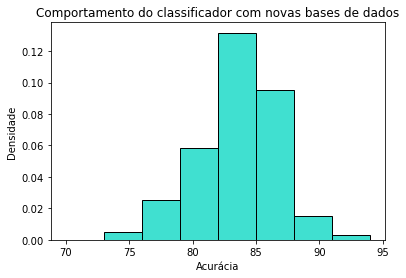

In [108]:
faixa = np.arange(int(minimo)-5,int(maximo)+5,3)
plt.hist(serie_acuracias, bins=faixa, color='turquoise', edgecolor='black', density = True)
plt.title('Comportamento do classificador com novas bases de dados')
plt.ylabel('Densidade')
plt.xlabel('Acurácia')

### Considerações do teste de qualidade
O gráfico acima possui comportamento simétrico, o que indica que há dispersão harmônica da qualidade de acertos pelos diferentes agrupamentos de notícias na base de dados. Pode-se inferir, também, aumento significativo na acurácia com tais alterações. Ou seja, a escolha da base de dados é um processo importante na definição de uma análise dos dados, pois reflete na precisão do método para encontrar as probabilidades.

### Melhorias úteis neste projeto
Em relação ao código, nota-se que o processo de obter as probabilidades é sistematizado e, portanto, repetitivo. Como melhoria, os cálculos poderiam ser inicialmente implementados como uma função única, que seria utilizada em quantas targets houvessem. Isso traria maior automatização e também encurtaria o código. Para além do código, também poderia ser considerada a adoção de outros métodos de classificação. Eles poderiam ser encontrados em sites referentes à Data Science e Machine Learning (é o caso de https://towardsdatascience.com/top-machine-learning-algorithms-for-classification-2197870ff501, que cita e explica novas metodologias como o próprio Naive Bayes e Decision Tree - que parece interessante ao tema escolhido nesse projeto.A respeito do último, há indicação de seus cálculos em https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680, o que seria uma fonte de pesquisa relevante para essa modalidade. 

___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nas notícias. Ex: stemming, lemmatization, stopwords
* CONSIDEROU mais de duas caterogias na variável Target e INCREMENTOU a quantidade de notícias, mantendo pelo menos 250 notícias por caterogia (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)
* Para Target com duas categorias: CRIOU pelo menos quatro categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante
* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto (pelo menos dois cenários, exceto aqueles já apresentados em sala pelos professores: por exemplo, filtro de spam)
* SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* FEZ o item Qualidade do Classificador a partir de novas separações das Notícias entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**

[Digital House](https://www.digitalhouse.com/br/blog/naive-bayes/#:~:text=Sendo%20um%20modelo%20adequado%20para,aplicar%20o%20conceito%20de%20probabilidade.)